In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

In [24]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            
            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [25]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [26]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [27]:
ml_list={
"LR":{
"SYN":LogisticRegression(C=0.233258,penalty="l2",solver="lbfgs" ),
"HTTP":LogisticRegression(C=0.0407033 ,penalty="l2",solver="newton-cg" ),
"ACK":LogisticRegression(C=0.0155943 ,penalty="l1",solver="liblinear" ),    
"UDP":LogisticRegression(C=0.0425062,penalty="l2",solver="liblinear" ),    
"ARP":LogisticRegression(C=0.176293 ,penalty="l1",solver="liblinear" ),
"SP":LogisticRegression(C=0.0000217794 ,penalty="l2",solver="lbfgs" ),    
"BF":LogisticRegression(C=0.00278972 ,penalty="l1",solver="liblinear" ),    
"OS":LogisticRegression(C=0.213319,penalty="l1",solver="liblinear" ),
"SCHD":LogisticRegression(C=8.2728,penalty="l1",solver="liblinear" ),    
"MHDis":LogisticRegression(C=0.321591,penalty="l1",solver="liblinear" )},   

"DT":{
"SYN":DecisionTreeClassifier(criterion="entropy",max_depth=5,max_features=19,min_samples_split=5 ),
"HTTP":DecisionTreeClassifier(criterion="entropy",max_depth=2,max_features=8,min_samples_split=2 ),                      
"ACK":DecisionTreeClassifier(criterion="gini",max_depth=32,max_features=1,min_samples_split=2),            
"UDP":DecisionTreeClassifier(criterion="gini",max_depth=7,max_features=3,min_samples_split=3 ),            
"ARP":DecisionTreeClassifier(criterion="entropy",max_depth=14,max_features=24,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="gini",max_depth=2,max_features=30,min_samples_split=5 ),            
"BF":DecisionTreeClassifier(criterion="gini",max_depth=23,max_features=9,min_samples_split=3 ),              
"OS":DecisionTreeClassifier(criterion="entropy",max_depth=1,max_features=39,min_samples_split=7 ),            
"SCHD":DecisionTreeClassifier(criterion="entropy",max_depth=6,max_features=40,min_samples_split=5 ),             
"MHDis":DecisionTreeClassifier(criterion="gini",max_depth=28,max_features=29,min_samples_split=5 )},
}

In [28]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [29]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")
folder("results/test")

## Calculation of evaluations

In [30]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [31]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)

                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             

In [32]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  

            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)

            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             

# GA output

In [33]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [34]:
file_list={
'../csvs\\dos-synflooding-1-dec.pcap_Flow.csv':"SYN",
'../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv':"HTTP",
'../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv':"ACK",
'../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv':"UDP",
'../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv':"ARP",
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SP",
'../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv':"BF",
'../csvs\\scan-portos-3-dec.pcap_Flow.csv':"OS",  
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SCHD",
'../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv':"MHDis"}

../csvs\dos-synflooding-1-dec.pcap_Flow.csv
['Src Port', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Max', 'Active Min', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.998    0.792   0.937  0.792  0.85   0.699  0.792    2.78      0.005
 1  SYN           0    2     0  LR    0.9

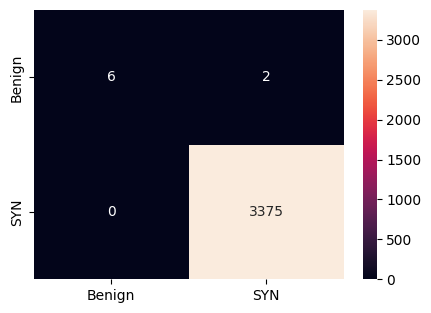





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    0.999    0.9     0.944  0.9    0.921  0.842  0.9      0.28      0.003
 1  SYN           0    2     0  DT    1        1       1      1      1      1      1        0.217     0.005
 2  SYN           0    3     0  DT    1        1       1      1      1      1      1        0.157     0.001
 3  SYN           0    4     0  DT    1        1       1      1      1      1      1        0.119     0.001
 4  SYN           0    5     0  DT    0.999    0.875   1      0.875  0.928  0.857  0.875    0.085     0.003
 5  SYN           0    1     1  DT    1        1       1      1      1      1      1        0.12      0.002
 6  SYN           0    2     1  DT    0.999    0.917   1      0.917  0.954  0.909  0.917    0.075     0.003
 7  SYN           0    3

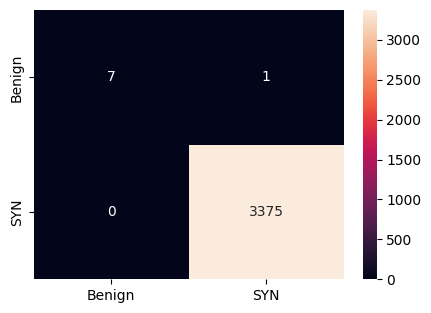





../csvs\mirai-httpflooding-4-dec.pcap_Flow.csv
['Dst Port', 'Flow Duration', 'Flow IAT Mean', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd Pkts/s', 'FIN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.913    0.902   0.92   0.902  0.909  0.818  0.902    0.661     0
 1  HTTP          0    2     0  LR    0.899    0.875   0.913  0.875  0.889  0.778  0.875    0.78      0
 2  HTTP          0    3     0  LR    0.918    0.903   0.925  0.903  0.912  0.824  0.903    0.511     0.001
 3  HTTP          0    4     0  LR    0.736    0.765   0.757  0.765  0.736  0.489  0.765    0.47      0
 4  HTTP          0    5     0  LR    0.688    0.728   0.74   0.728  0.687  0.411  0.728    0.454     0.001
 5  HTTP          0    1     1  LR    0.894    0.867   0.909  0.867  0.88

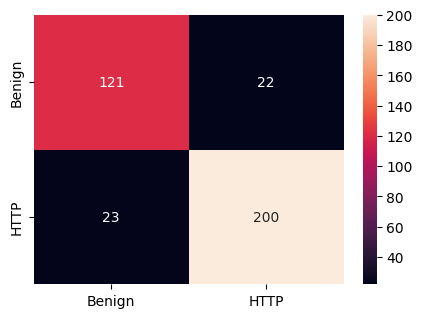





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.976    0.968   0.981  0.968  0.974  0.947  0.968    0.006     0.001
 1  HTTP          0    2     0  DT    0.976    0.969   0.981  0.969  0.974  0.948  0.969    0.009     0
 2  HTTP          0    3     0  DT    0.957    0.946   0.966  0.946  0.954  0.908  0.946    0.012     0.001
 3  HTTP          0    4     0  DT    0.962    0.95    0.971  0.95   0.959  0.918  0.95     0.006     0.001
 4  HTTP          0    5     0  DT    0.948    0.936   0.96   0.936  0.945  0.89   0.936    0.009     0.001
 5  HTTP          0    1     1  DT    0.959    0.948   0.969  0.948  0.956  0.913  0.948    0.006     0.001
 6  HTTP          0    2     1  DT    0.957    0.945   0.967  0.945  0.953  0.907  0.945    0.006     0.001
 7  HTTP          0    3    

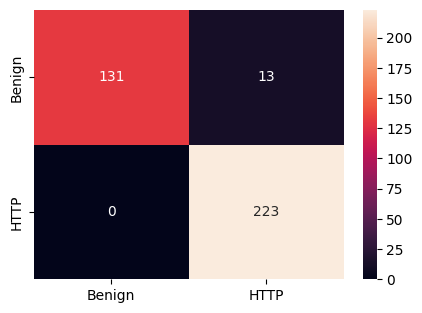





../csvs\mirai-ackflooding-4-dec.pcap_Flow.csv
['Flow IAT Mean', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.837    0.822   0.845  0.822  0.829  0.659  0.822    0.027     0.001
 1  ACK           0    2     0  LR    0.788    0.771   0.801  0.771  0.776  0.556  0.771    0.002     0
 2  ACK           0    3     0  LR    0.845    0.83    0.849  0.83   0.836  0.673  0.83     0.002     0
 3  ACK           0    4     0  LR    0.845    0.832   0.842  0.832  0.836  0.672  0.832    0.005     0
 4  ACK           0    5     0  LR    0.853    0.825   0.861  0.825  0.837  0.676  0.825    0.003     0
 5  ACK           0    1     1  LR    0.825    0.793   0.828  0.793  0.804  0.611  0.793    0.003     0.001
 6  ACK           0    2     1  LR    0.837    0.817   0.833  0.817  0.824 

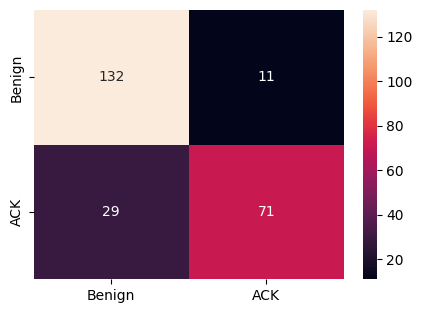





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.833    0.823   0.822  0.823  0.822  0.645  0.823    0.006     0
 1  ACK           0    2     0  DT    0.829    0.821   0.83   0.821  0.824  0.648  0.821    0.004     0.001
 2  ACK           0    3     0  DT    0.788    0.784   0.787  0.784  0.785  0.571  0.784    0.006     0.001
 3  ACK           0    4     0  DT    0.861    0.859   0.859  0.859  0.859  0.718  0.859    0.005     0.001
 4  ACK           0    5     0  DT    0.829    0.819   0.81   0.819  0.814  0.628  0.819    0.005     0
 5  ACK           0    1     1  DT    0.821    0.815   0.826  0.815  0.818  0.637  0.815    0.007     0.001
 6  ACK           0    2     1  DT    0.845    0.838   0.832  0.838  0.835  0.669  0.838    0.005     0.001
 7  ACK           0    3     1  

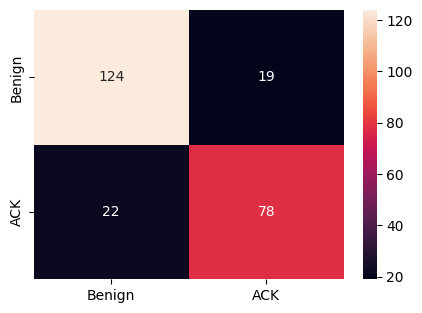





../csvs\mirai-udpflooding-4-dec.pcap_Flow.csv
['Src Port', 'Flow IAT Std', 'Fwd IAT Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR    0.973      0.5   0.487    0.5  0.493      0    0.5    0.008     0
 1  UDP           0    2     0  LR    0.987      0.5   0.493    0.5  0.497      0    0.5    0.003     0.001
 2  UDP           0    3     0  LR    0.966      0.5   0.483    0.5  0.491      0    0.5    0.003     0.001
 3  UDP           0    4     0  LR    0.953      0.5   0.476    0.5  0.488      0    0.5    0.005     0
 4  UDP           0    5     0  LR    0.986      0.5   0.493    0.5  0.497      0    0.5    0.005     0
 5  UDP           0    1     1  LR    0.966      0.5   0.483    0.5  0.491      0    0.5    0.003     0
 6  UDP           0    2     1  LR    0.973      

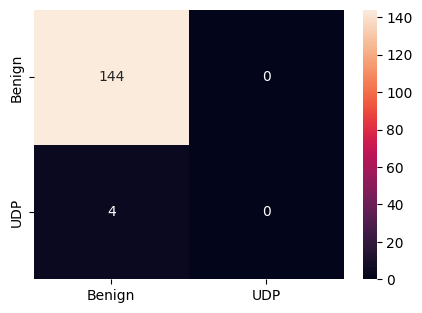





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    0.98     0.99    0.833  0.99   0.895  0.79   0.99     0.007     0.001
 1  UDP           0    2     0  DT    0.98     0.7     0.99   0.7    0.781  0.563  0.7      0.004     0.001
 2  UDP           0    3     0  DT    1        1       1      1      1      1      1        0.003     0.001
 3  UDP           0    4     0  DT    0.993    0.833   0.997  0.833  0.898  0.797  0.833    0.003     0
 4  UDP           0    5     0  DT    0.993    0.997   0.875  0.997  0.927  0.854  0.997    0.005     0.001
 5  UDP           0    1     1  DT    0.966    0.823   0.779  0.823  0.799  0.598  0.823    0.003     0
 6  UDP           0    2     1  DT    1        1       1      1      1      1      1        0.003     0.001
 7  UDP           0    3     1  

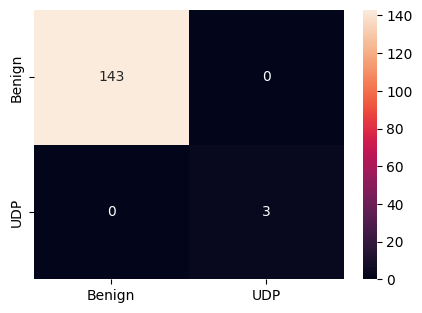





../csvs\mitm-arpspoofing-6-dec.pcap_Flow.csv
['Src Port', 'Dst Port', 'Protocol', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Std', 'Idle Mean', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.99     0.992   0.989  0.992  0.99   0.98   0.992    0.082

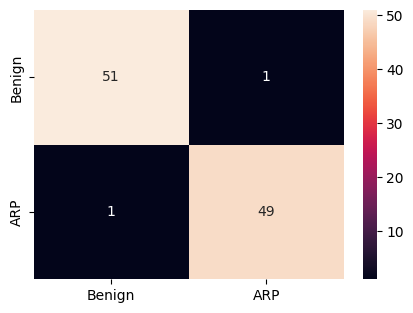





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.99     0.989   0.992  0.989  0.99   0.98   0.989    0.007     0
 1  ARP           0    2     0  DT    0.99     0.992   0.989  0.992  0.99   0.98   0.992    0.011     0.001
 2  ARP           0    3     0  DT    1        1       1      1      1      1      1        0.006     0
 3  ARP           0    4     0  DT    1        1       1      1      1      1      1        0.017     0
 4  ARP           0    5     0  DT    1        1       1      1      1      1      1        0.006     0.001
 5  ARP           0    1     1  DT    0.99     0.99    0.991  0.99   0.99   0.981  0.99     0.006     0.001
 6  ARP           0    2     1  DT    0.99     0.99    0.991  0.99   0.99   0.981  0.99     0.007     0
 7  ARP           0    3     1  DT    0.

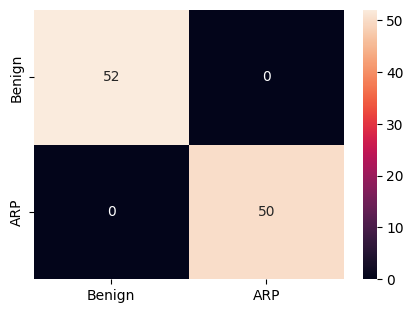





../csvs\scan-hostport-3-dec.pcap_Flow.csv
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd PSH Flags', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    1        1       1      1

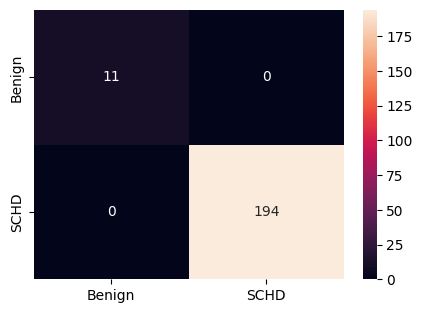





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT        1        1       1      1     1      1      1    0.007     0.001
 1  SCHD          0    2     0  DT        1        1       1      1     1      1      1    0.006     0
 2  SCHD          0    3     0  DT        1        1       1      1     1      1      1    0.012     0.001
 3  SCHD          0    4     0  DT        1        1       1      1     1      1      1    0.017     0.001
 4  SCHD          0    5     0  DT        1        1       1      1     1      1      1    0.016     0.001
 5  SCHD          0    1     1  DT        1        1       1      1     1      1      1    0.012     0.001
 6  SCHD          0    2     1  DT        1        1       1      1     1      1      1    0.036     0.004
 7  SCHD          0    3     1  DT   

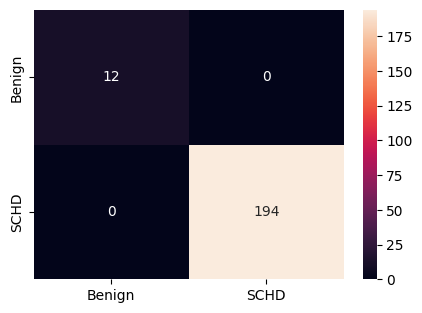





../csvs\mirai-hostbruteforce-5-dec.pcap_Flow.csv
['TotLen Fwd Pkts', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Min', 'Bwd Header Len', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            0    1     0  LR    0.858    0.574   0.689  0.574  0.592   0.204  0.574    0.015     0.001
 1  BF            0    2     0  LR    0.832    0.5     0.416  0.5    0.454   0      0.5      0.011     0.001
 2  BF            0    3     0  LR    0.822    0.497   0.413  0.497  0.451  -0.01   0.497    0.01      0.001
 3  BF            0    4     0  LR    0.858    0.491   0.436  0.491  0.462  -0.028  0.491    0.015     0
 4  BF            0    5     0  LR    0.862    0.563   0.768  0.563  0.576   0.187  0.563    0.013     0
 5  BF            0    1     1  LR    

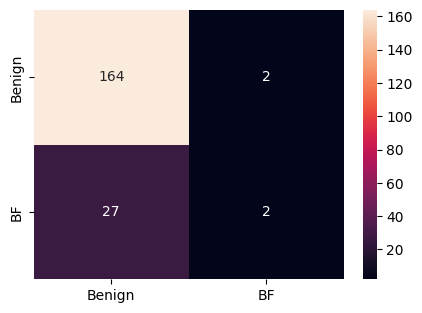





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.944    0.858   0.952  0.858  0.896  0.793  0.858    0.007     0.001
 1  BF            0    2     0  DT    0.919    0.853   0.834  0.853  0.843  0.685  0.853    0.007     0.001
 2  BF            0    3     0  DT    0.919    0.842   0.86   0.842  0.851  0.702  0.842    0.007     0.001
 3  BF            0    4     0  DT    0.934    0.824   0.837  0.824  0.83   0.661  0.824    0.008     0.001
 4  BF            0    5     0  DT    0.903    0.858   0.801  0.858  0.825  0.65   0.858    0.011     0.001
 5  BF            0    1     1  DT    0.924    0.846   0.856  0.846  0.85   0.701  0.846    0.008     0.001
 6  BF            0    2     1  DT    0.939    0.913   0.876  0.913  0.893  0.787  0.913    0.009     0.001
 7  BF            0    3

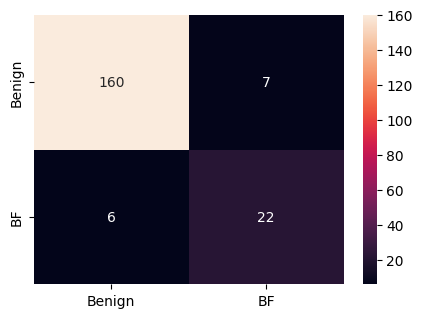





../csvs\scan-portos-3-dec.pcap_Flow.csv
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Max', 'Idle Mean', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  LR    0.988    0.938   0.993  0.938  0.963  0.927  

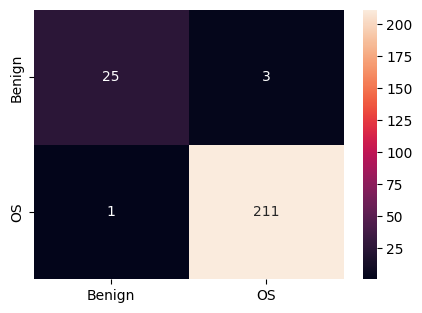





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.963    0.958   0.855  0.958  0.898  0.796  0.958    0.005     0.001
 1  OS            0    2     0  DT    0.967    0.917   0.94   0.917  0.928  0.856  0.917    0.005     0
 2  OS            0    3     0  DT    0.963    0.947   0.886  0.947  0.913  0.826  0.947    0.005     0.001
 3  OS            0    4     0  DT    0.971    0.956   0.922  0.956  0.938  0.876  0.956    0.006     0.001
 4  OS            0    5     0  DT    0.959    0.905   0.905  0.905  0.905  0.81   0.905    0.005     0.001
 5  OS            0    1     1  DT    0.967    0.954   0.909  0.954  0.93   0.86   0.954    0.005     0.002
 6  OS            0    2     1  DT    0.967    0.928   0.9    0.928  0.914  0.828  0.928    0.005     0.001
 7  OS            0    3    

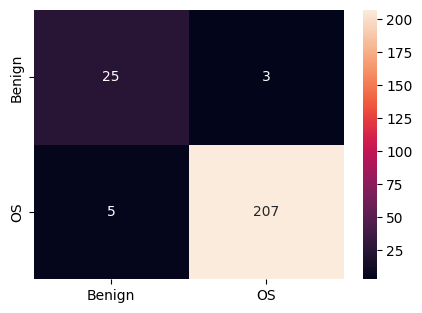





../csvs\mirai-hostbruteforce-3-dec.pcap_Flow.csv
['Src Port', 'Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Var', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  LR    0.868    0.632   0.858  0.632  0.67   0.362  0.632    0.092     0.001
 1  MHDis         0    2     0  LR    0.906    0.713   0.873  0.713  0.762  0.53   0.713    0.224     

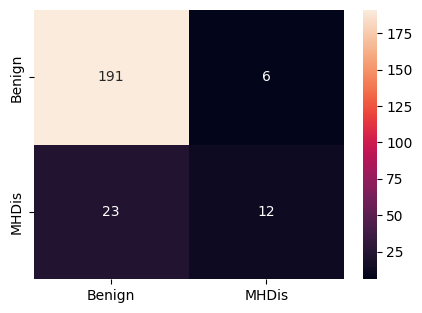





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT    0.974    0.946   0.946  0.946  0.946  0.891  0.946    0.021     0
 1  MHDis         0    2     0  DT    0.987    0.935   0.993  0.935  0.962  0.923  0.935    0.024     0
 2  MHDis         0    3     0  DT    0.983    0.968   0.968  0.968  0.968  0.936  0.968    0.02      0
 3  MHDis         0    4     0  DT    0.983    0.963   0.98   0.963  0.972  0.943  0.963    0.016     0.001
 4  MHDis         0    5     0  DT    0.991    0.995   0.978  0.995  0.986  0.972  0.995    0.023     0.001
 5  MHDis         0    1     1  DT    0.987    0.983   0.974  0.983  0.978  0.957  0.983    0.019     0.001
 6  MHDis         0    2     1  DT    0.996    0.998   0.986  0.998  0.992  0.983  0.998    0.011     0.001
 7  MHDis         0    3     1  DT  

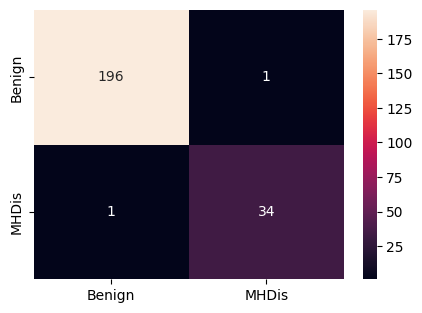

In [35]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   

# SS

In [36]:
file_list_session={
"SYN":[ '../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-2-dec.pcap_Flow.csv',],
"HTTP":['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-httpflooding-1-dec.pcap_Flow.csv'],
"ACK":['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv'],
"UDP":[ '../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-udpflooding-1-dec.pcap_Flow.csv'],
"ARP":[ '../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs\\mitm-arpspoofing-4-dec.pcap_Flow.csv'],
"SP":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"BF":[ '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv'],
"OS":['../csvs\\scan-portos-3-dec.pcap_Flow.csv','../csvs\\scan-portos-6-dec.pcap_Flow.csv'],
"SCHD":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"MHDis":['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-2-dec.pcap_Flow.csv']}

SYN
['Src Port', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Max', 'Active Min', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.997    0.873   0.869  0.873  0.871  0.742  0.873    1.835     0.009
 1  SYN           0    1     1  LR    0.997    0.873   0.869  0.873  0.871  0.742

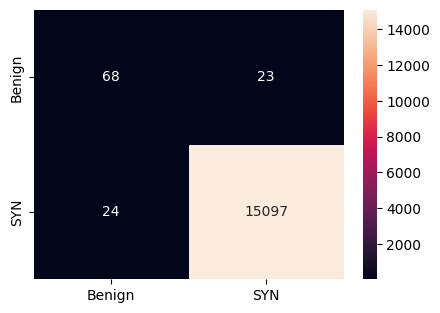





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    1        0.978   1      0.978  0.989  0.977  0.978    0.081     0.004
 1  SYN           0    1     1  DT    1        0.984   1      0.984  0.992  0.983  0.984    0.078     0.004
 2  SYN           0    1     2  DT    1        1       0.989  1      0.995  0.989  1        0.065     0.004
 3  SYN           0    1     3  DT    1        0.978   1      0.978  0.989  0.977  0.978    0.071     0.005
 4  SYN           0    1     4  DT    1        0.972   0.988  0.972  0.98   0.961  0.972    0.084     0.004
 5  SYN           0    1     5  DT    0.999    0.961   0.988  0.961  0.974  0.949  0.961    0.057     0.005
 6  SYN           0    1     6  DT    1        0.989   1      0.989  0.994  0.989  0.989    0.071     0.004
 7  SYN           0    1

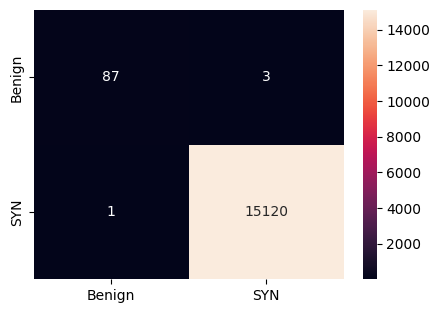





HTTP
['Dst Port', 'Flow Duration', 'Flow IAT Mean', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd Pkts/s', 'FIN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.914    0.901   0.934  0.901  0.91  0.822  0.901    0.516     0.001
 1  HTTP          0    1     1  LR    0.914    0.901   0.934  0.901  0.91  0.822  0.901    0.502     0.001
 2  HTTP          0    1     2  LR    0.914    0.901   0.934  0.901  0.91  0.822  0.901    0.489     0.001
 3  HTTP          0    1     3  LR    0.914    0.901   0.934  0.901  0.91  0.822  0.901    0.494     0
 4  HTTP          0    1     4  LR    0.914    0.901   0.934  0.901  0.91  0.822  0.901    0.505     0
 5  HTTP          0    1     5  LR    0.914    0.901   0.934  0.901  0.91  0.822  0.901    0.488     0
 6  HTTP       

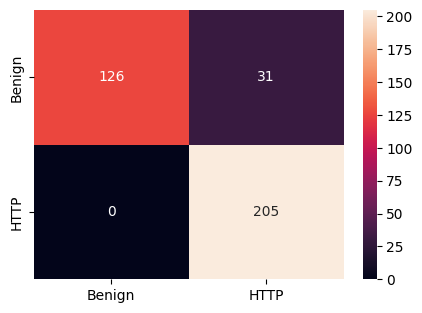





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.961    0.955   0.968  0.955  0.96   0.92  0.955    0.008     0.001
 1  HTTP          0    1     1  DT    0.961    0.955   0.968  0.955  0.96   0.92  0.955    0.008     0.001
 2  HTTP          0    1     2  DT    0.961    0.955   0.968  0.955  0.96   0.92  0.955    0.009     0
 3  HTTP          0    1     3  DT    0.961    0.955   0.968  0.955  0.96   0.92  0.955    0.016     0
 4  HTTP          0    1     4  DT    0.961    0.955   0.968  0.955  0.96   0.92  0.955    0.009     0
 5  HTTP          0    1     5  DT    0.961    0.955   0.968  0.955  0.96   0.92  0.955    0.008     0
 6  HTTP          0    1     6  DT    0.961    0.955   0.968  0.955  0.96   0.92  0.955    0.009     0
 7  HTTP          0    1     7  DT    0.961    0.955 

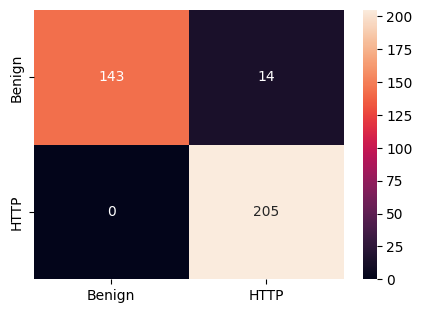





ACK
['Flow IAT Mean', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.268     0.57   0.508   0.57  0.228  0.008   0.57    0.003     0.001
 1  ACK           0    1     1  LR    0.268     0.57   0.508   0.57  0.228  0.008   0.57    0.005     0.001
 2  ACK           0    1     2  LR    0.268     0.57   0.508   0.57  0.228  0.008   0.57    0.003     0
 3  ACK           0    1     3  LR    0.268     0.57   0.508   0.57  0.228  0.008   0.57    0.003     0
 4  ACK           0    1     4  LR    0.268     0.57   0.508   0.57  0.228  0.008   0.57    0.005     0
 5  ACK           0    1     5  LR    0.269     0.57   0.508   0.57  0.228  0.008   0.57    0.009     0
 6  ACK           0    1     6  LR    0.268     0.57   0.508   0.57  0.228  0.008   0.57    0.022     0.014
 7  ACK  

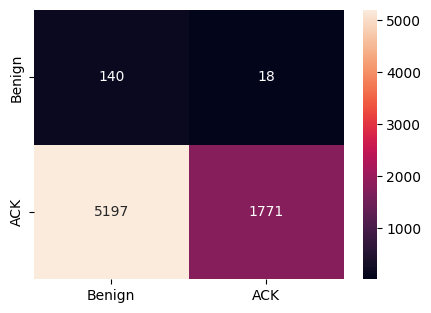





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.796    0.794   0.538  0.794  0.516  0.111  0.794    0.02      0.002
 1  ACK           0    1     1  DT    0.796    0.794   0.538  0.794  0.516  0.111  0.794    0.008     0.003
 2  ACK           0    1     2  DT    0.796    0.794   0.538  0.794  0.516  0.111  0.794    0.008     0.003
 3  ACK           0    1     3  DT    0.796    0.794   0.538  0.794  0.516  0.111  0.794    0.007     0.002
 4  ACK           0    1     4  DT    0.796    0.794   0.538  0.794  0.516  0.111  0.794    0.017     0.001
 5  ACK           0    1     5  DT    0.796    0.794   0.538  0.794  0.516  0.111  0.794    0.007     0.001
 6  ACK           0    1     6  DT    0.796    0.794   0.538  0.794  0.516  0.111  0.794    0.007     0.002
 7  ACK           0    1

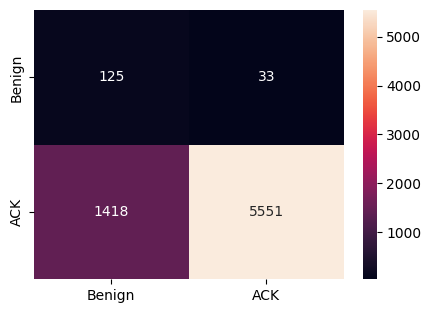





UDP
['Src Port', 'Flow IAT Std', 'Fwd IAT Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.003     0.001
 1  UDP           0    1     1  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.004     0
 2  UDP           0    1     2  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.005     0.001
 3  UDP           0    1     3  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.004     0
 4  UDP           0    1     4  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.011     0
 5  UDP           0    1     5  LR    0.406      0.5   0.203    0.5  0.289      0    0.5    0.003     0.001
 6  UDP           0    1     6  LR    0.406      0.5   0.203    0.5  0.289      0    0.

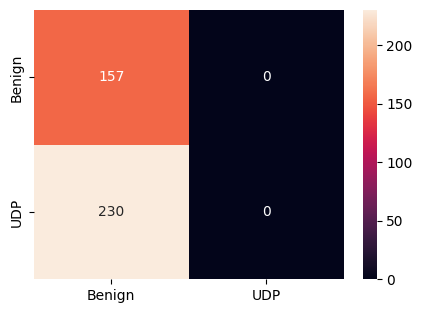





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    0.974    0.978   0.97   0.978  0.973  0.947  0.978    0.003     0
 1  UDP           0    1     1  DT    0.974    0.978   0.97   0.978  0.973  0.947  0.978    0.002     0.001
 2  UDP           0    1     2  DT    0.974    0.978   0.97   0.978  0.973  0.947  0.978    0.003     0
 3  UDP           0    1     3  DT    0.974    0.978   0.97   0.978  0.973  0.947  0.978    0.003     0.001
 4  UDP           0    1     4  DT    0.974    0.978   0.97   0.978  0.973  0.947  0.978    0.004     0
 5  UDP           0    1     5  DT    0.974    0.978   0.97   0.978  0.973  0.947  0.978    0.003     0
 6  UDP           0    1     6  DT    0.974    0.978   0.97   0.978  0.973  0.947  0.978    0.003     0
 7  UDP           0    1     7  DT    0.946 

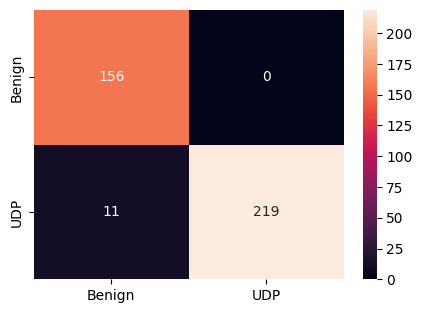





ARP
['Src Port', 'Dst Port', 'Protocol', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Std', 'Idle Mean', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.955    0.939   0.959  0.939  0.948  0.896  0.939    0.092     0
 1  ARP           0    1     1  LR

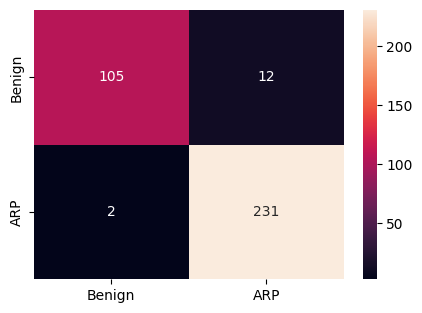





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.972    0.966   0.97   0.966  0.968  0.936  0.966    0.012     0.001
 1  ARP           0    1     1  DT    0.983    0.981   0.981  0.981  0.981  0.962  0.981    0.007     0.001
 2  ARP           0    1     2  DT    0.977    0.975   0.975  0.975  0.975  0.949  0.975    0.009     0
 3  ARP           0    1     3  DT    0.955    0.949   0.949  0.949  0.949  0.898  0.949    0.008     0
 4  ARP           0    1     4  DT    0.989    0.987   0.987  0.987  0.987  0.975  0.987    0.009     0
 5  ARP           0    1     5  DT    0.952    0.947   0.945  0.947  0.946  0.892  0.947    0.007     0.001
 6  ARP           0    1     6  DT    0.972    0.968   0.968  0.968  0.968  0.936  0.968    0.012     0
 7  ARP           0    1     7  DT    0.

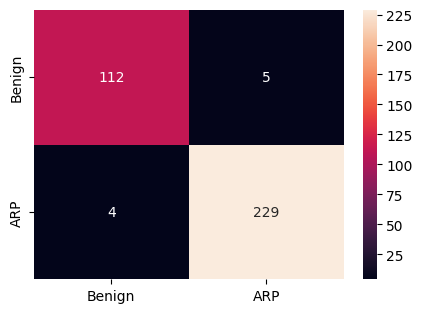





SP
['Protocol', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    0.984    0.943   0.959  0.943  0.951  0.902  0.943    0.165     0
 1  SP            0    1     1  LR    0.984    0.943   0.959  0.943  0.951  0.902  0.943    0.201     0.001
 2  SP            0    1     2  LR    0.984    0.94

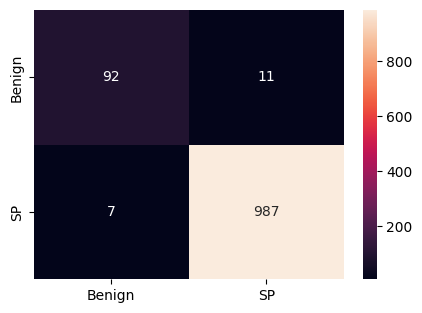





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0.001
 1  SP            0    1     1  DT    0.965    0.977   0.866  0.977  0.912  0.824  0.977    0.003     0.001
 2  SP            0    1     2  DT    0.965    0.977   0.866  0.977  0.912  0.824  0.977    0.003     0.001
 3  SP            0    1     3  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0.001
 4  SP            0    1     4  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0.001
 5  SP            0    1     5  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.006     0.002
 6  SP            0    1     6  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0.001
 7  SP            0    1

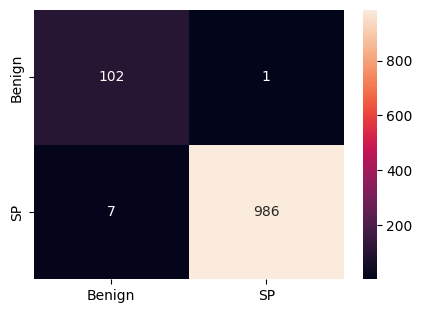





BF
['TotLen Fwd Pkts', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Min', 'Bwd Header Len', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.014     0
 1  BF            0    1     1  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.013     0.001
 2  BF            0    1     2  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.011     0.001
 3  BF            0    1     3  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.011     0.001
 4  BF            0    1     4  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.012     0.001
 5  BF            0    1     5  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.57

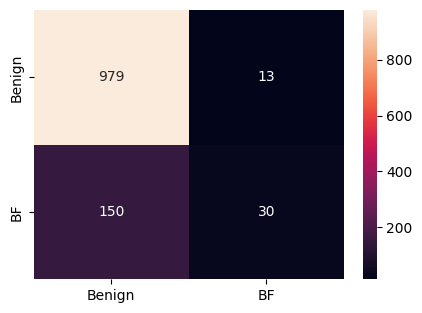





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.922    0.808   0.872  0.808  0.835  0.671  0.808    0.014     0
 1  BF            0    1     1  DT    0.914    0.794   0.853  0.794  0.82   0.64   0.794    0.011     0.001
 2  BF            0    1     2  DT    0.915    0.797   0.854  0.797  0.822  0.644  0.797    0.01      0.001
 3  BF            0    1     3  DT    0.918    0.799   0.865  0.799  0.827  0.655  0.799    0.009     0.001
 4  BF            0    1     4  DT    0.917    0.799   0.863  0.799  0.826  0.652  0.799    0.011     0
 5  BF            0    1     5  DT    0.916    0.801   0.858  0.801  0.825  0.651  0.801    0.013     0
 6  BF            0    1     6  DT    0.914    0.792   0.855  0.792  0.819  0.638  0.792    0.01      0.001
 7  BF            0    1     7  DT  

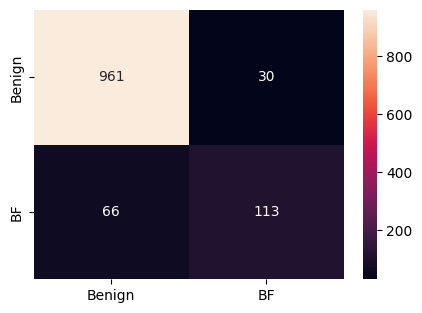





OS
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Max', 'Idle Mean', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  LR    0.994    0.923   0.968  0.923  0.944  0.888  0.923    1.302     0.002
 1  OS      

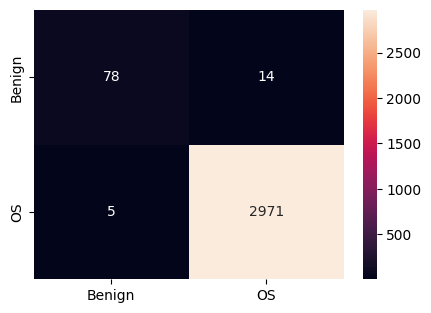





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.985    0.824   0.906  0.824  0.86   0.72  0.824    0.006     0.001
 1  OS            0    1     1  DT    0.985    0.824   0.906  0.824  0.86   0.72  0.824    0.014     0.001
 2  OS            0    1     2  DT    0.985    0.824   0.906  0.824  0.86   0.72  0.824    0.005     0.009
 3  OS            0    1     3  DT    0.985    0.824   0.906  0.824  0.86   0.72  0.824    0.008     0.001
 4  OS            0    1     4  DT    0.985    0.824   0.906  0.824  0.86   0.72  0.824    0.005     0.001
 5  OS            0    1     5  DT    0.985    0.824   0.906  0.824  0.86   0.72  0.824    0.006     0.001
 6  OS            0    1     6  DT    0.985    0.824   0.906  0.824  0.86   0.72  0.824    0.007     0.001
 7  OS            0    1     7  D

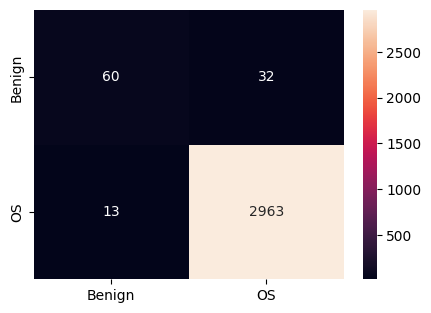





SCHD
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd PSH Flags', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.007   

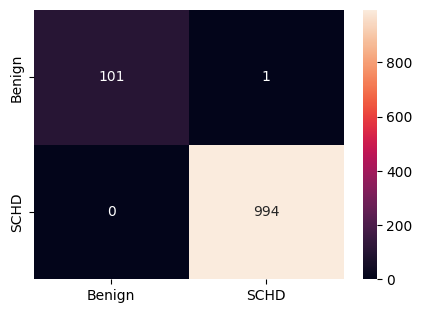





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.007     0.001
 1  SCHD          0    1     1  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.009     0.001
 2  SCHD          0    1     2  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.008     0
 3  SCHD          0    1     3  DT    0.989    0.985   0.954  0.985  0.969  0.938  0.985    0.008     0.001
 4  SCHD          0    1     4  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.007     0.001
 5  SCHD          0    1     5  DT    0.989    0.985   0.954  0.985  0.969  0.938  0.985    0.042     0.001
 6  SCHD          0    1     6  DT    0.965    0.977   0.866  0.977  0.912  0.824  0.977    0.009     0
 7  SCHD          0    1     7  

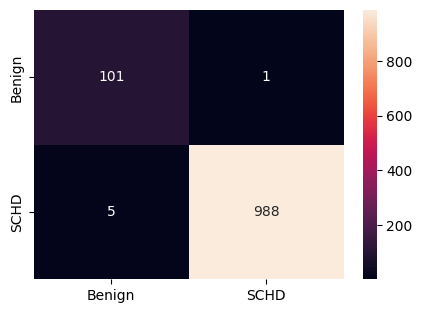





MHDis
['Src Port', 'Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Var', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  ------  -----  -------  --------
 0  MHDis         0    1     0  LR    0.771    0.488   0.447  0.488  0.45  -0.034  0.488    0.241     0
 1  MHDis         0    1     1  LR    0.771    0.488   0.447  0.488  0.45  -0.034  0.488    0.196     0.001
 2  MHDis         0    1     2  LR    0.7

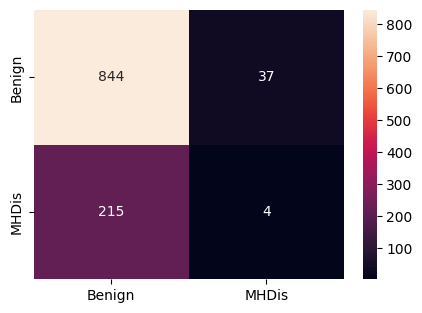





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  MHDis         0    1     0  DT    0.726    0.519   0.524  0.519  0.518   0.042  0.519    0.038     0
 1  MHDis         0    1     1  DT    0.733    0.523   0.53   0.523  0.522   0.051  0.523    0.171     0.001
 2  MHDis         0    1     2  DT    0.728    0.522   0.528  0.522  0.521   0.048  0.522    0.044     0.002
 3  MHDis         0    1     3  DT    0.69     0.431   0.388  0.431  0.408  -0.166  0.431    0.022     0.001
 4  MHDis         0    1     4  DT    0.729    0.524   0.531  0.524  0.524   0.053  0.524    0.026     0.001
 5  MHDis         0    1     5  DT    0.729    0.524   0.531  0.524  0.524   0.053  0.524    0.047     0.004
 6  MHDis         0    1     6  DT    0.72     0.501   0.501  0.501  0.497   0.002  0.501    0.014     0.001
 7  MHDis         0

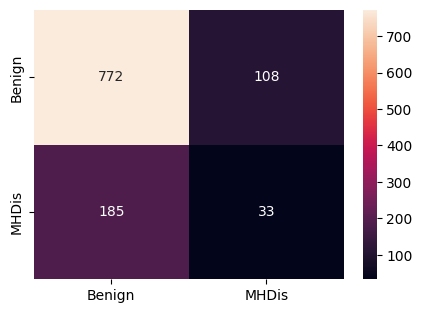

In [37]:
folder("results/val/")

for file in file_list_session:
    print(file)
    feature=feature_list[file]
    train=file_list_session[file][0]
    test=file_list_session[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   

# TEST

In [38]:
file_list={
'SYN': ['../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-6-dec.pcap_Flow.csv'],
'HTTP': ['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\http-flood -maze.csv'],
'ACK': ['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-ackflooding-2-dec.pcap_Flow.csv'],
'UDP': ['../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-udpflooding-2-dec.pcap_Flow.csv'],
'ARP': ['../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs\\mitm-arpspoofing-5-dec.pcap_Flow.csv'],
'SP': ['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs\\Edge-Port Scanning attack.pcap_Flow.csv'],
'BF': ['../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv'],
'OS': ['../csvs\\scan-portos-3-dec.pcap_Flow.csv', '../csvs\\BoT-IoT_OSScan.csv'],
'SCHD': ['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs\\scan-hostport-5-dec.pcap_Flow.csv'],
'MHDis': ['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv', '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv']}

SYN
['Src Port', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Max', 'Active Min', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  LR    0.998    0.931   0.922  0.931  0.926  0.853  0.931    2.788     0.002
 1  SYN           1    1     1  LR    0.998    0.931   0.922  0.931  0.926  0.853

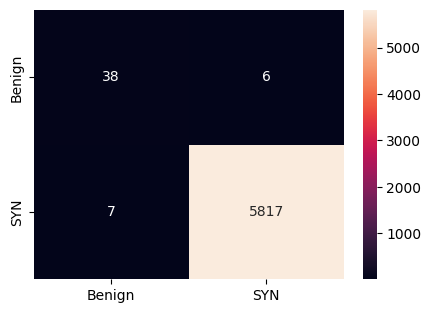





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  DT    1        0.989   1      0.989  0.994  0.988  0.989    0.092     0.002
 1  SYN           1    1     1  DT    1        0.989   1      0.989  0.994  0.988  0.989    0.09      0.002
 2  SYN           1    1     2  DT    1        0.977   1      0.977  0.988  0.977  0.977    0.067     0.003
 3  SYN           1    1     3  DT    1        0.977   1      0.977  0.988  0.977  0.977    0.072     0.001
 4  SYN           1    1     4  DT    1        0.989   1      0.989  0.994  0.988  0.989    0.061     0.002
 5  SYN           1    1     5  DT    1        0.989   1      0.989  0.994  0.988  0.989    0.094     0.002
 6  SYN           1    1     6  DT    0.998    0.886   0.985  0.886  0.93   0.86   0.886    0.086     0.003
 7  SYN           1    1

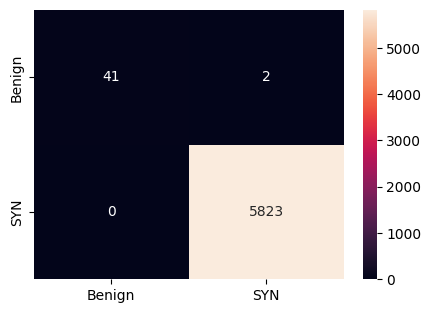





HTTP
['Dst Port', 'Flow Duration', 'Flow IAT Mean', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd Pkts/s', 'FIN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  LR        1        1       1      1     1      1      1    0.774     0.001
 1  HTTP          1    1     1  LR        1        1       1      1     1      1      1    0.584     0.001
 2  HTTP          1    1     2  LR        1        1       1      1     1      1      1    0.539     0
 3  HTTP          1    1     3  LR        1        1       1      1     1      1      1    0.518     0
 4  HTTP          1    1     4  LR        1        1       1      1     1      1      1    0.51      0
 5  HTTP          1    1     5  LR        1        1       1      1     1      1      1    0.542     0.001
 6  HTTP       

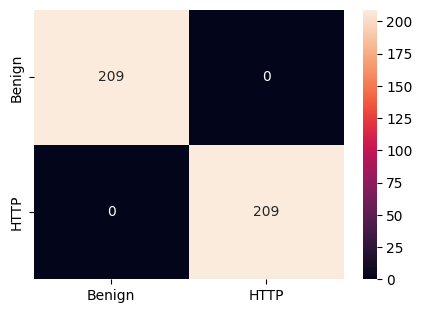





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  DT        1        1       1      1     1      1      1    0.012     0
 1  HTTP          1    1     1  DT        1        1       1      1     1      1      1    0.009     0
 2  HTTP          1    1     2  DT        1        1       1      1     1      1      1    0.009     0
 3  HTTP          1    1     3  DT        1        1       1      1     1      1      1    0.007     0.001
 4  HTTP          1    1     4  DT        1        1       1      1     1      1      1    0.008     0
 5  HTTP          1    1     5  DT        1        1       1      1     1      1      1    0.009     0
 6  HTTP          1    1     6  DT        1        1       1      1     1      1      1    0.008     0
 7  HTTP          1    1     7  DT        1        1     

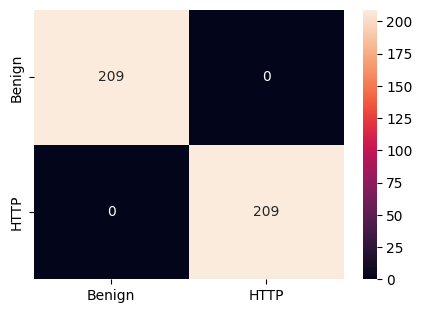





ACK
['Flow IAT Mean', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  LR    0.825    0.805   0.833  0.805  0.813  0.628  0.805    0.004     0.001
 1  ACK           1    1     1  LR    0.825    0.805   0.833  0.805  0.813  0.628  0.805    0.004     0
 2  ACK           1    1     2  LR    0.825    0.804   0.833  0.804  0.812  0.626  0.804    0.003     0
 3  ACK           1    1     3  LR    0.825    0.804   0.833  0.804  0.812  0.626  0.804    0.002     0.001
 4  ACK           1    1     4  LR    0.825    0.804   0.833  0.804  0.812  0.626  0.804    0.004     0
 5  ACK           1    1     5  LR    0.826    0.806   0.834  0.806  0.814  0.63   0.806    0.004     0.001
 6  ACK           1    1     6  LR    0.825    0.804   0.833  0.804  0.812  0.626  0.804    0.003     0
 7  ACK  

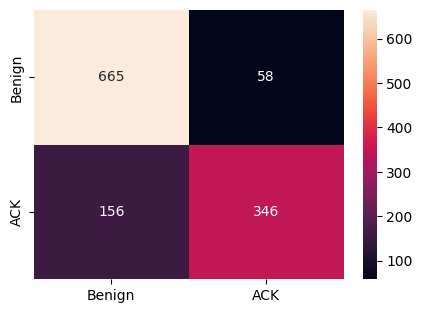





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.006     0
 1  ACK           1    1     1  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.005     0
 2  ACK           1    1     2  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.005     0.001
 3  ACK           1    1     3  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.006     0.001
 4  ACK           1    1     4  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.045     0.001
 5  ACK           1    1     5  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.014     0.001
 6  ACK           1    1     6  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.009     0.001
 7  ACK           1    1     7  

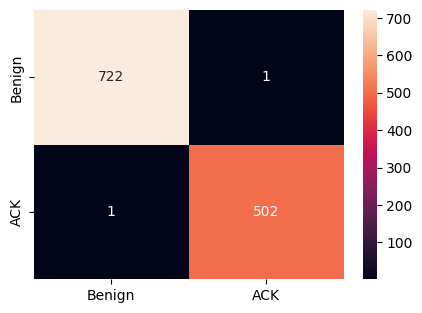





UDP
['Src Port', 'Flow IAT Std', 'Fwd IAT Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  LR    0.973      0.5   0.487    0.5  0.493      0    0.5    0.003     0
 1  UDP           1    1     1  LR    0.973      0.5   0.487    0.5  0.493      0    0.5    0.003     0.001
 2  UDP           1    1     2  LR    0.973      0.5   0.487    0.5  0.493      0    0.5    0.004     0
 3  UDP           1    1     3  LR    0.973      0.5   0.487    0.5  0.493      0    0.5    0.003     0
 4  UDP           1    1     4  LR    0.973      0.5   0.487    0.5  0.493      0    0.5    0.003     0
 5  UDP           1    1     5  LR    0.973      0.5   0.487    0.5  0.493      0    0.5    0.003     0.001
 6  UDP           1    1     6  LR    0.973      0.5   0.487    0.5  0.493      0    0.5   

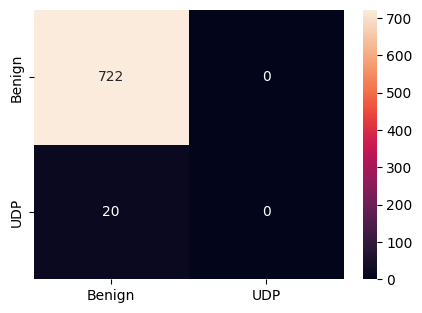





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           1    1     0  DT        1        1       1      1     1      1      1    0.009     0.001
 1  UDP           1    1     1  DT        1        1       1      1     1      1      1    0.004     0
 2  UDP           1    1     2  DT        1        1       1      1     1      1      1    0.005     0
 3  UDP           1    1     3  DT        1        1       1      1     1      1      1    0.003     0
 4  UDP           1    1     4  DT        1        1       1      1     1      1      1    0.003     0
 5  UDP           1    1     5  DT        1        1       1      1     1      1      1    0.005     0.001
 6  UDP           1    1     6  DT        1        1       1      1     1      1      1    0.003     0.001
 7  UDP           1    1     7  DT        1      

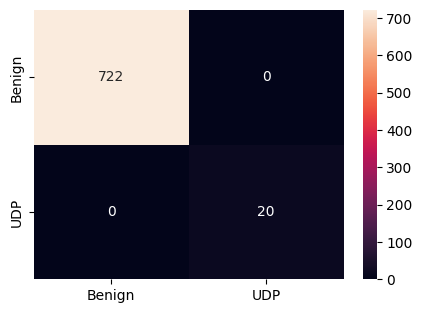





ARP
['Src Port', 'Dst Port', 'Protocol', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Std', 'Idle Mean', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           1    1     0  LR    0.955    0.949   0.956  0.949  0.952  0.905  0.949    0.099     0.001
 1  ARP           1    1     1

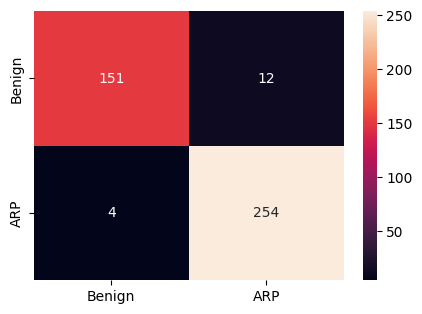





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           1    1     0  DT    0.976    0.976   0.974  0.976  0.975  0.95   0.976    0.008     0.001
 1  ARP           1    1     1  DT    0.972    0.973   0.968  0.973  0.97   0.941  0.973    0.007     0
 2  ARP           1    1     2  DT    0.955    0.954   0.951  0.954  0.953  0.906  0.954    0.009     0
 3  ARP           1    1     3  DT    0.96     0.964   0.954  0.964  0.958  0.916  0.964    0.014     0.002
 4  ARP           1    1     4  DT    0.965    0.967   0.96   0.967  0.963  0.926  0.967    0.014     0
 5  ARP           1    1     5  DT    0.953    0.951   0.949  0.951  0.95   0.901  0.951    0.008     0.001
 6  ARP           1    1     6  DT    0.96     0.96    0.956  0.96   0.958  0.916  0.96     0.007     0.001
 7  ARP           1    1     7  DT  

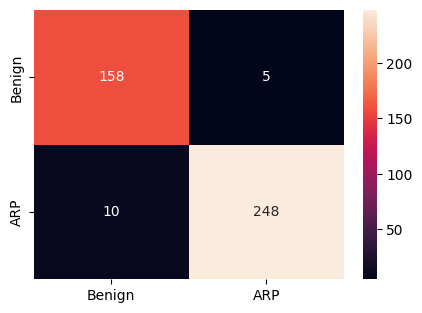





SP
['Protocol', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  LR        1    0.997       1  0.997  0.998  0.997  0.997    0.234     0.003
 1  SP            1    1     1  LR        1    0.997       1  0.997  0.998  0.997  0.997    0.189     0.002
 2  SP            1    1     2  LR        1    

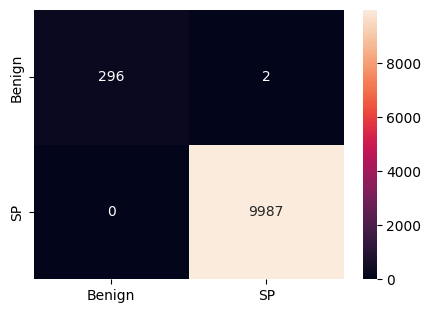





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            1    1     0  DT        1        1       1      1     1      1      1    0.002     0.002
 1  SP            1    1     1  DT        1        1       1      1     1      1      1    0.003     0.003
 2  SP            1    1     2  DT        1        1       1      1     1      1      1    0.003     0.003
 3  SP            1    1     3  DT        1        1       1      1     1      1      1    0.005     0.003
 4  SP            1    1     4  DT        1        1       1      1     1      1      1    0.002     0.003
 5  SP            1    1     5  DT        1        1       1      1     1      1      1    0.001     0.004
 6  SP            1    1     6  DT        1        1       1      1     1      1      1    0.002     0.004
 7  SP            1    1     7  D

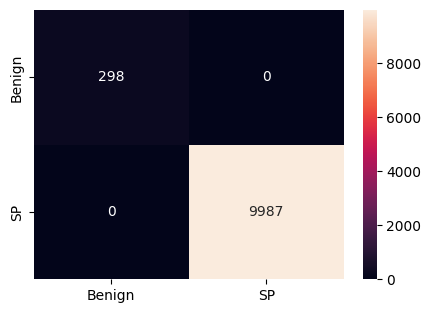





BF
['TotLen Fwd Pkts', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Min', 'Bwd Header Len', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.019     0.001
 1  BF            1    1     1  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.012     0.001
 2  BF            1    1     2  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.015     0
 3  BF            1    1     3  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.013     0.001
 4  BF            1    1     4  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577    0.015     0
 5  BF            1    1     5  LR    0.861    0.577   0.782  0.577  0.596  0.223  0.577   

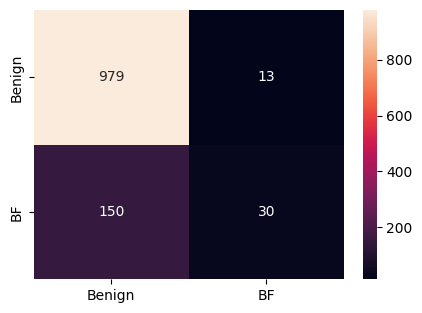





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  DT    0.916    0.791   0.865  0.791  0.822  0.644  0.791    0.012     0.001
 1  BF            1    1     1  DT    0.91     0.786   0.847  0.786  0.811  0.624  0.786    0.009     0
 2  BF            1    1     2  DT    0.913    0.799   0.848  0.799  0.82   0.641  0.799    0.009     0.001
 3  BF            1    1     3  DT    0.914    0.797   0.852  0.797  0.821  0.642  0.797    0.008     0
 4  BF            1    1     4  DT    0.911    0.793   0.845  0.793  0.816  0.632  0.793    0.01      0.001
 5  BF            1    1     5  DT    0.915    0.802   0.852  0.802  0.824  0.648  0.802    0.009     0.001
 6  BF            1    1     6  DT    0.913    0.789   0.853  0.789  0.816  0.634  0.789    0.008     0.001
 7  BF            1    1     7  

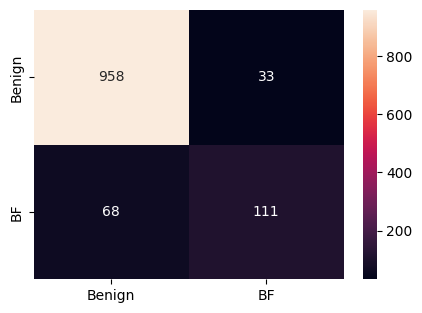





OS
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Max', 'Idle Mean', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  LR    0.984    0.955   0.906  0.955  0.929  0.857  0.955    0.93      0.006
 1  OS      

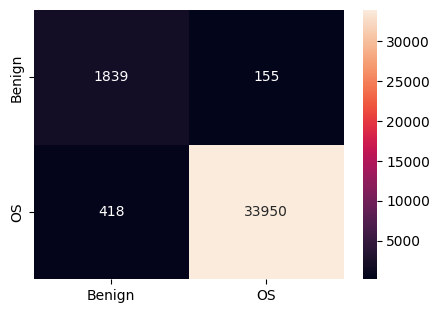





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  DT    0.982    0.986   0.881  0.986  0.926  0.852  0.986    0.005     0.009
 1  OS            1    1     1  DT    0.982    0.986   0.881  0.986  0.926  0.852  0.986    0.008     0.009
 2  OS            1    1     2  DT    0.982    0.986   0.881  0.986  0.926  0.852  0.986    0.007     0.011
 3  OS            1    1     3  DT    0.982    0.986   0.881  0.986  0.926  0.852  0.986    0.007     0.01
 4  OS            1    1     4  DT    0.982    0.986   0.881  0.986  0.926  0.852  0.986    0.014     0.01
 5  OS            1    1     5  DT    0.982    0.986   0.881  0.986  0.926  0.852  0.986    0.007     0.009
 6  OS            1    1     6  DT    0.982    0.986   0.881  0.986  0.926  0.852  0.986    0.005     0.01
 7  OS            1    1   

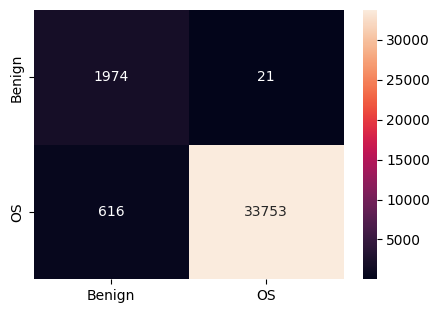





SCHD
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd PSH Flags', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  LR    1        1       1      1      1      1      1        0.013   

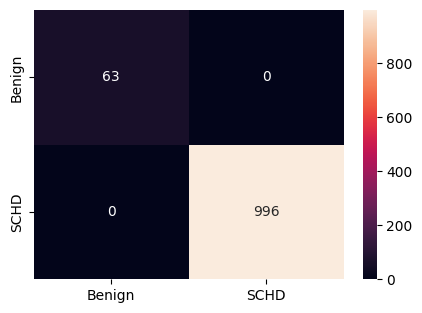





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  DT    0.997    0.998   0.978  0.998  0.988  0.976  0.998    0.007     0.001
 1  SCHD          1    1     1  DT    1        1       1      1      1      1      1        0.008     0.001
 2  SCHD          1    1     2  DT    1        1       1      1      1      1      1        0.008     0.001
 3  SCHD          1    1     3  DT    1        1       1      1      1      1      1        0.007     0
 4  SCHD          1    1     4  DT    0.997    0.998   0.978  0.998  0.988  0.976  0.998    0.007     0.001
 5  SCHD          1    1     5  DT    1        1       1      1      1      1      1        0.008     0
 6  SCHD          1    1     6  DT    1        1       1      1      1      1      1        0.009     0.001
 7  SCHD          1    1     7  

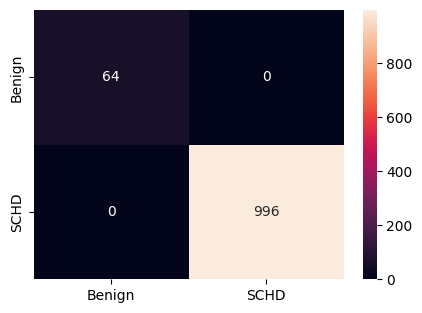





MHDis
['Src Port', 'Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Var', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  LR    0.879    0.65    0.809  0.65   0.689  0.39   0.65     0.302     0.001
 1  MHDis         1    1     1  LR    0.879    0.65    0.809  0.65   0.689  0.39   0.65     0.204     0.001
 2  MHDis         1    1     2  LR   

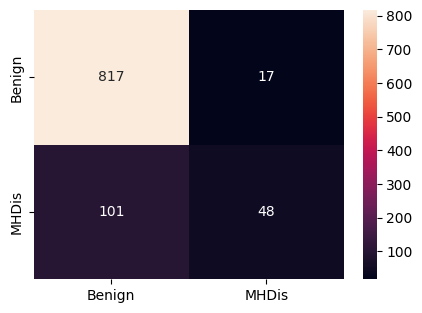





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  DT    0.986    0.959   0.986  0.959  0.972  0.943  0.959    0.023     0.002
 1  MHDis         1    1     1  DT    0.98     0.947   0.973  0.947  0.959  0.919  0.947    0.029     0.001
 2  MHDis         1    1     2  DT    0.983    0.959   0.973  0.959  0.966  0.932  0.959    0.023     0.001
 3  MHDis         1    1     3  DT    0.984    0.96    0.976  0.96   0.968  0.936  0.96     0.045     0.001
 4  MHDis         1    1     4  DT    0.984    0.96    0.976  0.96   0.968  0.936  0.96     0.031     0.001
 5  MHDis         1    1     5  DT    0.989    0.966   0.991  0.966  0.978  0.955  0.966    0.036     0.001
 6  MHDis         1    1     6  DT    0.984    0.963   0.973  0.963  0.968  0.936  0.963    0.063     0.001
 7  MHDis         1    1

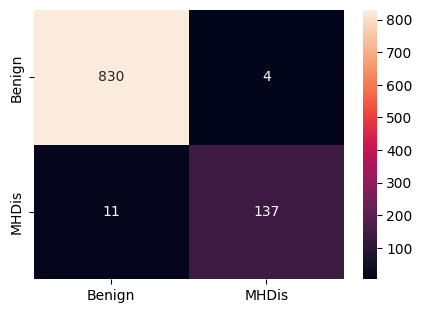

In [39]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  

In [40]:
print(2)

2


In [41]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]
    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df = df.mean(numeric_only=True)
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 138.88it/s]

    Attack    ML         Acc     b_Acc      Prec       Rec        F1       kap       ROC       tra-T       test-T
--  --------  ----  --------  --------  --------  --------  --------  --------  --------  ----------  -----------
 0  ACK       DT    0.998369  0.998314  0.998314  0.998314  0.998314  0.996629  0.998314  0.0105039   0.00075469
 1  ACK       LR    0.825041  0.804323  0.833054  0.804323  0.812378  0.627336  0.804323  0.00329792  0.000400376
 2  ARP       DT    0.962175  0.962514  0.958495  0.962514  0.960343  0.920697  0.962514  0.00886455  0.000700641
 3  ARP       LR    0.959338  0.952817  0.961551  0.952817  0.956788  0.913608  0.952817  0.101225    0.00065484
 4  BF        DT    0.913652  0.79415   0.852871  0.79415   0.819241  0.639166  0.79415   0.00999775  0.000802207
 5  BF        LR    0.860922  0.576781  0.782407  0.576781  0.596104  0.223039  0.576781  0.0153224   0.000601244
 6  HTTP      DT    1         1         1         1         1         1         1         

In [42]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)

ACK
ARP
BF
HTTP
MHDis
OS
SCHD
SP
SYN
UDP
